# Project-4: Latent Factor Model (Advanced)
## Group 8: Suraj and Pankajdeer



In [18]:
# import libraries
import random
import os
import numpy as np
import pandas as pd
import collections
from pathlib import Path

import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.ticker as ticker

font = {'size'   : 18}    
plt.rc('font', **font)

from random import randrange
from shutil import copyfile

from sklearn.metrics import mean_squared_error


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
class latentfactormodel:

  def __init__(self, num_items, num_users, num_factors, global_mean, init_scale=5.0):
    # initialize the class
    self.num_factors = num_factors

    self.global_mean = global_mean

    # user and movies biases are also optimized
    self.item_bias = np.zeros(num_items)
    self.user_bias = np.zeros(num_users)

    self.Q = np.random.rand(num_factors, num_items+1)*np.sqrt(init_scale/num_factors)
    self.P = np.random.rand(num_factors, num_users+1)*np.sqrt(init_scale/num_factors)

  def predict(self, user_id, item_id):
    # predict the rating for particular user and movie
    r = self.global_mean + self.item_bias[item_id] + self.user_bias[user_id] + np.sum(self.Q[:,item_id] * self.P[:,user_id])
    return r
  
  def RMSE(self, y_actual, y_predicted):
    # compute the RMSE between actual and predicted rating
    rms = np.sqrt(mean_squared_error(y_actual, y_predicted))
    return round(rms,4)
    
  def error(self, ratings):
    # predict the rating for all users and movies. 
    # then compute the RMSE
    ratings_true = []
    ratings_predicted = []
    for user_id, item_id, rating_true in ratings:
      rating_predicted = self.predict(user_id, item_id)
      ratings_true.append(rating_true)
      ratings_predicted.append(rating_predicted)
    rmse = self.RMSE(ratings_true, ratings_predicted)

    return rmse
  
  def cost(self, ratings, lambda_):
    # compute the cost function 
    # the cost function is modified to consider the entries of user and movie biases
    ratings_true = []
    ratings_predicted = []
    for user_id, item_id, rating_true in ratings:
      rating_predicted = self.predict(user_id, item_id)
      ratings_true.append(rating_true)
      ratings_predicted.append(rating_predicted)
    cost = 0
    cost += np.sum((np.array(ratings_true) - np.array(rating_predicted))**2)
    cost += lambda_*np.sum(self.P**2)
    cost += lambda_*np.sum(self.Q**2)
    cost += lambda_*np.sum(self.item_bias**2)
    cost += lambda_*np.sum(self.user_bias**2)

    return cost

  def step(self,user_id, item_id, rating_true, mu, lambda_):
    # perform one iteration of SGD for one example in the train dataset
    error_ui = (rating_true - self.predict(user_id,item_id))
    self.item_bias[item_id] += mu*(error_ui - lambda_*self.item_bias[item_id])
    self.user_bias[user_id] += mu*(error_ui - lambda_*self.user_bias[user_id])
    self.P[:,user_id] += mu*(error_ui*self.Q[:,item_id] - lambda_*self.P[:,user_id])
    self.Q[:,item_id] += mu*(error_ui*self.P[:,user_id] - lambda_*self.Q[:,item_id])
    
    

In [13]:
TRAIN_RATINGS_PATH = '/content/drive/My Drive/Coursework/CS 5683_Big_Data/Project-4/training_dataset.csv'
TEST_RATINGS_PATH = '/content/drive/My Drive/Coursework/CS 5683_Big_Data/Project-4/test_dataset.csv'

# import train and test dataset
train_data = pd.read_csv(TRAIN_RATINGS_PATH,
            sep=",", engine="python",
            names=["user_id", "item_id", "rating"],
            usecols=[0, 1, 2], skiprows=1)

test_data = pd.read_csv(TEST_RATINGS_PATH,
            sep=",", engine="python",
            names=["user_id", "item_id", "rating"],
            usecols=[0, 1, 2], skiprows=1)

num_users = max(train_data.user_id.max(), test_data.user_id.max()) 
num_items = max(train_data.item_id.max(), test_data.item_id.max())
global_mean = train_data.rating.mean()
train_data, test_data = train_data.values, test_data.values


In [22]:
# define parameters of the latent factor model
num_epochs_list = [50]
mu_list = [0.01]
lambda_list = [0.1]
num_factors_list = [30]

filename_global = f"error_global.txt"
file_global = open(filename_global, "a", buffering=1)
count = 0

for num_epochs in num_epochs_list:
  for mu in mu_list:
    for lambda_ in lambda_list:
      for num_factors in num_factors_list:
        lf = latentfactormodel(num_items + 1, num_users + 1, num_factors, global_mean)
        filename = f"error_{count}.txt"
        file = open(filename, "a", buffering=1)

        # store rmse, cost at each iteration
        rmse_cost_plot = np.zeros((num_epochs,5))

        # define the object for latent factor model
        lf = latentfactormodel(num_items + 1, num_users + 1, num_factors, global_mean)

        print("{:<10} {:<15} {:<15} ".format('Iteration', 'Train RMSE', 'Test TMSE'))
        epochs = 0
        print("{:<10} {:<15} {:<15} ".format(epochs, lf.error(train_data), lf.error(test_data)))

        rmse_cost_plot[epochs,0] = epochs 
        rmse_cost_plot[epochs,1], rmse_cost_plot[epochs,2] = lf.error(train_data), lf.error(test_data)
        rmse_cost_plot[epochs,3], rmse_cost_plot[epochs,4] = lf.cost(train_data,lambda_), lf.cost(test_data, lambda_)

        for epochs in range(num_epochs):
          for idx in np.random.permutation(train_data.shape[0]):
            lf.step(*train_data[idx], mu, lambda_,)
          print("{:<10} {:<15} {:<15} ".format(epochs, lf.error(train_data), lf.error(test_data)))
          print(epochs, lf.error(train_data), lf.error(test_data), file=file)

          # store the RMSE and cost
          rmse_cost_plot[epochs,0] = epochs
          rmse_cost_plot[epochs,1], rmse_cost_plot[epochs,2]  =  lf.error(train_data), lf.error(test_data)
          rmse_cost_plot[epochs,3], rmse_cost_plot[epochs,4] = lf.cost(train_data,lambda_), lf.cost(test_data, lambda_)
        
        # print(count, num_epochs, mu, lambda_, num_factors, lf.error(train_data), lf.error(test_data))
        # print(count, num_epochs, mu, lambda_, num_factors, lf.error(train_data), lf.error(test_data), file=file_global)

        file.close()
        count += 1
        
file_global.close()


Iteration  Train RMSE      Test TMSE       
0          1.6908          1.7799          
0          0.9746          0.9864          
1          0.9392          0.9571          
2          0.9237          0.9441          
3          0.9144          0.935           
4          0.9079          0.9288          
5          0.9029          0.9257          
6          0.8987          0.9243          
7          0.8943          0.9193          
8          0.8901          0.9189          
9          0.8859          0.9169          
10         0.8812          0.913           
11         0.8762          0.9106          
12         0.8709          0.9088          
13         0.8654          0.9053          
14         0.8601          0.9026          
15         0.8549          0.9014          
16         0.8496          0.8972          
17         0.8443          0.8972          
18         0.8395          0.8948          
19         0.8345          0.8934          
20         0.8295          0.891

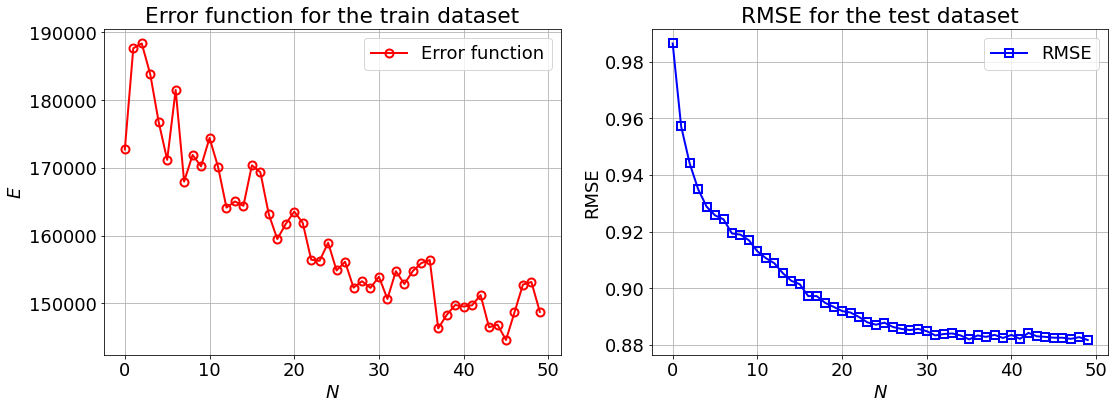

In [23]:
# RMSE and cost plotting
fig, ax = plt.subplots(1,2,figsize=(18,6))
axs = ax.flat

axs[0].plot(rmse_cost_plot[:,0], rmse_cost_plot[:,3], 'ro-', lw=2, ms=8, mew=2, fillstyle='none',  label='Error function')
axs[1].plot(rmse_cost_plot[:,0], rmse_cost_plot[:,2], 'bs-', lw=2, ms=8, mew=2, fillstyle='none',  label='RMSE')

axs[0].grid()
axs[0].set_xlabel('$N$')
axs[0].set_ylabel('$E$')
axs[0].set_title('Error function for the train dataset')
axs[0].legend(loc=0)

axs[1].grid()
axs[1].set_xlabel('$N$')
axs[1].set_ylabel('RMSE')
axs[1].set_title('RMSE for the test dataset')
axs[1].legend(loc=0)


# plt.suptitle('Latent factor model ')

# fig.tight_layout()
plt.show()